In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time

In [2]:
trainf = pd.read_csv('house_feature_train.csv')
trainp = pd.read_csv('house_price_train.csv')
testf = pd.read_csv('house_feature_test.csv')
testp = pd.read_csv('house_price_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

,house_id,house_age,distance_MRT,number_convenience_stores,latitude,longitude,house_price
0,210,5.2,390.5684,5,24.97937,121.54245,2724.84
1,190,35.3,616.5735,8,24.97945,121.53642,1789.29
2,328,15.9,1497.7130,3,24.97003,121.51696,556.96
3,5,7.1,2175.0300,3,24.96305,121.51254,1030.41
4,412,8.1,104.8101,5,24.96674,121.54067,2756.25


In [3]:
#Creating a set of predictors from which we need to find the best subset of predictors
X = train[['house_age','number_convenience_stores','latitude', 'longitude','distance_MRT']]

In [4]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('np.log(house_price)~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [5]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [6]:
#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
models_best = pd.DataFrame(columns=["Rsquared", "model"])

#a for loop that finds the best model for each subset size
tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 5 models on 1 predictors in 0.04551291465759277 seconds.
Processed 10 models on 2 predictors in 0.060678958892822266 seconds.
Processed 10 models on 3 predictors in 0.0638270378112793 seconds.
Processed 5 models on 4 predictors in 0.04068899154663086 seconds.
Processed 1 models on 5 predictors in 0.011404037475585938 seconds.
Total elapsed time: 0.23928499221801758 seconds.


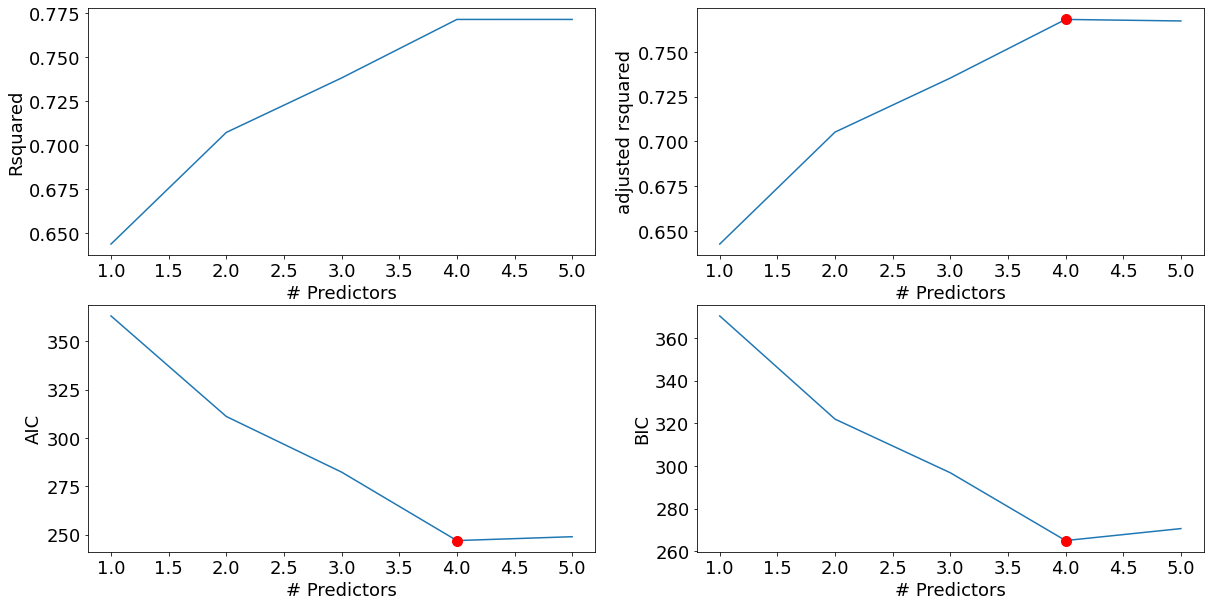

In [7]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [8]:
best_subset_model = models_best.loc[4,'model']
models_best.loc[4,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(house_price)   R-squared:                       0.772
Model:                             OLS   Adj. R-squared:                  0.768
Method:                  Least Squares   F-statistic:                     228.0
Date:                 Mon, 27 Feb 2023   Prob (F-statistic):           2.79e-85
Time:                         13:20:52   Log-Likelihood:                -118.47
No. Observations:                  275   AIC:                             246.9
Df Residuals:                      270   BIC:                             265.0
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  -459.0262     58.231     -7.883      0.000    -573.671    -344.381
house_age                    -0.0131      0.002     -6.451      0.000      -0.017      -0.009
number_convenience_stores     0.0597      0.010      6.271      0.000       0.041       0.078
latitude                     18.6828      2.332      8.012      0.000      14.092      23.274
distance_MRT                 -0.0003   2.53e-05    -12.221      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        4.422   Durbin-Watson:                   2.261
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                5.555
Skew:                           0.073   Prob(JB):                       0.0622
Kurtosis:                       3.681   Cond. No.                     4.25e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Compare RMSEs 
    RMSE of the model with all pred.s 
    RMSE of the model with the single best subset 
    Check if the best subset RMSE is lower

For the example above, the change in RMSE is minimal 
    the number of pred.s was low 
    the total effect of these predictors were limited 

In [9]:
#creating the interaction terms and running the same algorithms
#Creating a dataframe with all the predictors
X = train[['house_age', 'distance_MRT', 'number_convenience_stores','latitude','longitude']]
#Since 'X' will change when we include interactions, we need a backup containing all individual predictors
X_backup = train[['house_age', 'distance_MRT', 'number_convenience_stores','latitude','longitude']]

In [11]:
#Including 2-factor interactions of predictors in train and 'X'. Note that we need train to develop the model, and X to 
#find 'k' variable subsets from amongst all the predictors under consideration
for combo in itertools.combinations(X_backup.columns, 2):    
    train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
    test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
    X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 

In [12]:
models_best = pd.DataFrame(columns=["Rsquared", "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 15 models on 1 predictors in 0.11006283760070801 seconds.
Processed 105 models on 2 predictors in 0.561190128326416 seconds.
Processed 455 models on 3 predictors in 2.796420097351074 seconds.
Processed 1365 models on 4 predictors in 9.423472881317139 seconds.
Processed 3003 models on 5 predictors in 24.040611028671265 seconds.
Processed 5005 models on 6 predictors in 46.43419313430786 seconds.
Processed 6435 models on 7 predictors in 65.32798910140991 seconds.
Processed 6435 models on 8 predictors in 71.89001274108887 seconds.
Processed 5005 models on 9 predictors in 58.42204475402832 seconds.
Processed 3003 models on 10 predictors in 39.35493302345276 seconds.
Processed 1365 models on 11 predictors in 18.33052921295166 seconds.
Processed 455 models on 12 predictors in 6.658989906311035 seconds.
Processed 105 models on 13 predictors in 1.5764780044555664 seconds.
Processed 15 models on 14 predictors in 0.2438356876373291 seconds.
Processed 1 models on 15 predictors in 0.02087

Rmse of the best subset model will be lower
    the rmse of the model with all pred.s (originals and in. terms)
    because some interactions are not useful o caputure the genral trend in the data

The complete picture: 
    train a model with all your pred.s
    add transformations and interactions- some are useful 
    get rid of the redundant/harmful ones by subset selection/reg. 
    